# Static behaviour of sheet piles based on strain gauges

In this script, we analyse the static behaviour of the sheet piles, both single and grouted, based on the strain gauges data. This analysis is heavily based on the work by Amin Moussaid, see '`Spundsteif_Analyse_essais_flexion.ipynb`'.
The data has been preprocessed in the script '`05_catman.ipynb`'.

**Note:** For some reason, when converting this Jupyter Notebook to a Pdf file, the 3D-plots are omitted. These figures can be requested at cecilia.ulmke@bfh.ch.

In [ ]:
#test_flag_colab
from google.colab import drive
drive.mount('/content/drive')

# working directory: drive/MyDrive/spundsteif
%cd '/content/drive/MyDrive/spundsteif'

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/spundsteif


# Import the libraries

In [ ]:
import pandas as pd
import numpy as np
import io
import csv
from datetime import datetime, date, timedelta

from google.colab import files

from copy import copy

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn import linear_model

import re

# Import the data

## Read the preprocessed strain gauges data

In [ ]:
STRAIN_GAUGES_FILE_NAME = './data/df_preprocessed_data_strain_gauges.csv'
df_dms = pd.read_csv(STRAIN_GAUGES_FILE_NAME, delimiter=',')


# drop the columns containing information we don't need
useless_cols = ['Tempa', 'Tempb', 'Tempc', 'KMD1', 'KMD2', 'KMD1kompensiert', 'KMD2kompensiert']
df_dms = df_dms.drop(columns=useless_cols, axis=1)


# covert the column 'Zeit' into python datetime objects and sort in chronological order
for index, row in df_dms.iterrows():
  df_dms.at[index, 'Zeit'] = datetime.strptime(df_dms.at[index, 'Zeit'], '%Y-%m-%d')
  df_dms.at[index, 'Zeit'] = df_dms.at[index, 'Zeit'].strftime('%d-%m-%Y')
  df_dms.at[index, 'Zeit'] = datetime.strptime(df_dms.at[index, 'Zeit'], '%d-%m-%Y')

df_dms = df_dms.sort_values('Zeit', ascending=True)
df_dms.set_index('Zeit', inplace=True)

df_dms

,Temperatur aussen,EH11,EV12,EH21,EV22,EV32,EV33,W12,W22,VH31,...,EV11,EV31,VH12,VH13,VH22,VH32,VH33,W13,W23,W33
Zeit,,,,,,,,,,,,,,,,,,,,,
2021-12-05,2.194236,-40.418528,-42.456540,-66.316346,-55.582515,-54.327693,-88.846493,-24.443380,-56.457260,-230.953088,...,123.337719,97.495614,81.135965,86.758772,34.679825,73.570175,76.166667,68.614035,NaN,88.149123
2021-12-12,0.887579,-41.099335,-43.942639,-65.884826,-65.204063,-64.915125,-101.366304,-330.680186,-57.503193,-219.023037,...,131.811404,103.021930,91.820175,68.706140,32.100877,83.149123,90.166667,78.929825,NaN,96.254386
2021-12-19,0.659028,-37.097666,-40.652361,-64.072161,-61.786556,-59.757214,-93.302631,-629.988231,-55.019530,-253.562630,...,140.285088,108.548246,102.504386,50.653509,29.521930,92.728070,104.166667,89.245614,NaN,104.359649
2021-12-26,-0.794951,-35.887601,-39.647119,-62.262819,-57.380301,-53.803326,-86.943740,-569.653334,-58.287954,-254.499782,...,117.681481,102.594444,98.959259,-3.498148,14.111111,80.274074,99.307407,85.998148,71.600000,101.533333
2022-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,87.192593,93.727778,91.803704,-66.809259,-4.555556,62.229630,89.662963,79.309259,54.800000,95.933333
2022-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,56.703704,84.861111,84.648148,-130.120370,-23.222222,44.185185,80.018519,72.620370,38.000000,90.333333
2022-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.214815,75.994444,77.492593,-193.431481,-41.888889,26.140741,70.374074,65.931481,21.200000,84.733333
2022-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.274074,67.127778,70.337037,-256.742593,-60.555556,8.096296,60.729630,59.242593,4.400000,79.133333
2022-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-34.762963,58.261111,63.181481,-320.053704,-79.222222,-9.948148,51.085185,52.553704,-12.400000,73.533333


## Read the information concerning the sensors

The coordinate system is defined as follows: the origin is located in the interlock at the upper rim of the sheet piles. The z-axis is positive in upward direction, the y-axis points towards the retained soil, and the x-axis lies in the sheet pile wall axis.

The single piles (in German "Paar Einzelbohlen") have unfortunately been installed the wrong way: the side that was supposed to face the excavation ended up facing the soil, and the side that was supposed to face the soil ended up facing the excavation.
The grouted piles (in German "vorverklebte Bohlen") were installed correctly.

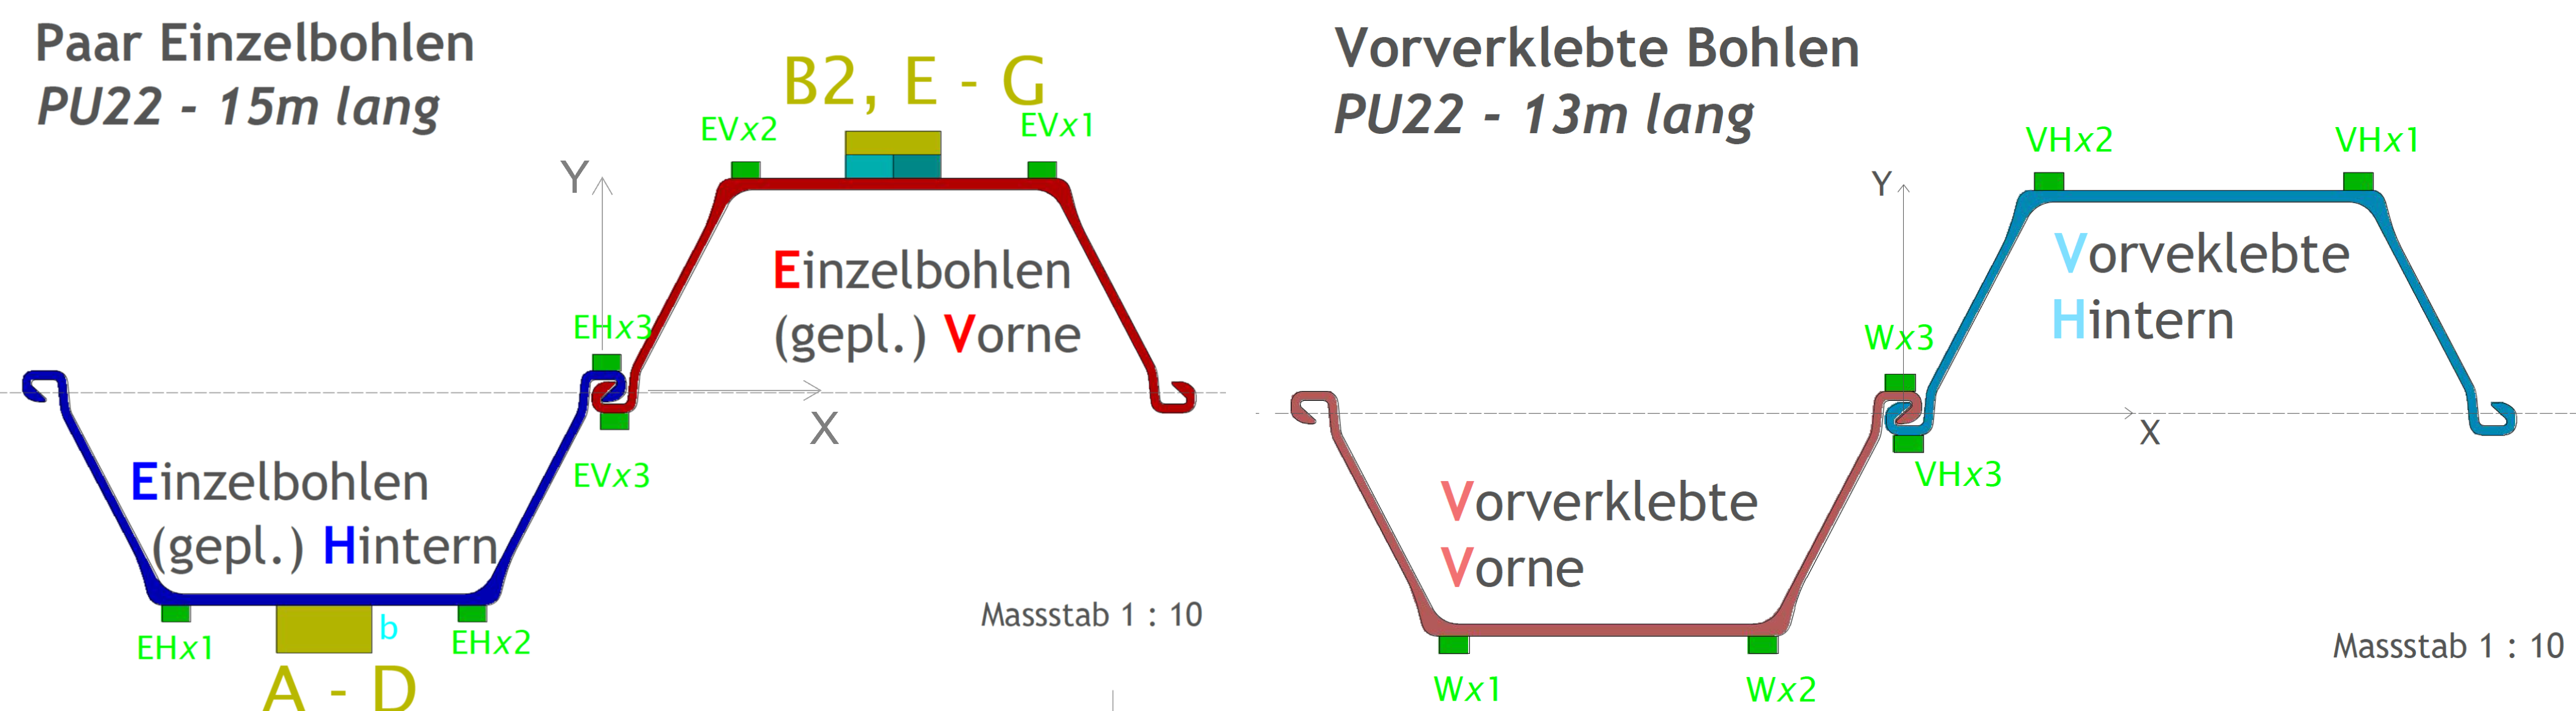

In [ ]:
POSITION_SENSORS = './data/df_proprietes.csv'
df_proprietes = pd.read_csv(POSITION_SENSORS, delimiter=';')

# add a column with the z-coordinate
df_proprietes['z'] = -df_proprietes['depth']

# add a column with the pile index (1 for vorne, 2 for hinten)
for index, row in df_proprietes.iterrows():
  if df_proprietes.at[index, 'type_bohlen'] == 'paar einzelbohlen':
    if  re.search("EV", df_proprietes.at[index, 'name_sensor']): # Einzehlbohle (geplant) vorne
      df_proprietes.at[index, 'index_pile'] = 2
    else:
      df_proprietes.at[index, 'index_pile'] = 1

  else:
    if  re.search("W", df_proprietes.at[index, 'name_sensor']): # Verklebte Bohle vorne
      df_proprietes.at[index, 'index_pile'] = 1
    else:
      df_proprietes.at[index, 'index_pile'] = 2

df_proprietes#.head(20)

# Note: the data in the "face" column is wrong! However, this is not a problem,
# because the analysis is based exclusivey on the coordinates (x, y, z).

,name_sensor,depth,x,y,type_sensor,units,face,type_bohlen,z,index_pile
0,EV11,2.0,0.45,0.225,DMS,micrometer pro Meter,passive,paar einzelbohlen,-2.0,2.0
1,EV12,2.0,0.15,0.225,DMS,micrometer pro Meter,passive,paar einzelbohlen,-2.0,2.0
2,EV13,2.0,0.00,-0.022,DMS,micrometer pro Meter,aktive,paar einzelbohlen,-2.0,2.0
3,EV21,4.5,0.45,0.225,DMS,micrometer pro Meter,passive,paar einzelbohlen,-4.5,2.0
4,EV22,4.5,0.15,0.225,DMS,micrometer pro Meter,passive,paar einzelbohlen,-4.5,2.0
5,EV23,4.5,0.00,-0.022,DMS,micrometer pro Meter,aktive,paar einzelbohlen,-4.5,2.0
6,EV31,7.5,0.45,0.225,DMS,micrometer pro Meter,passive,paar einzelbohlen,-7.5,2.0
7,EV32,7.5,0.15,0.225,DMS,micrometer pro Meter,passive,paar einzelbohlen,-7.5,2.0
8,EV33,7.5,0.00,-0.022,DMS,micrometer pro Meter,aktive,paar einzelbohlen,-7.5,2.0
9,EH11,2.0,-0.45,-0.225,DMS,micrometer pro Meter,aktive,paar einzelbohlen,-2.0,1.0


## Read the PU22 steel sheet pile cross-section data

In [ ]:
PU22_CROSS_SECTION = './data/PU22.csv'
df_PU22 = pd.read_csv(PU22_CROSS_SECTION, delimiter=';')
df_PU22
# x and y are in meters

,x,y,pile_nr
0,-0.60,0.000,1
1,-0.60,0.022,1
2,-0.45,-0.225,1
3,-0.15,-0.225,1
4,0.00,0.022,1
5,0.00,-0.022,2
6,0.15,0.225,2
7,0.45,0.225,2
8,0.60,-0.022,2
9,0.60,0.000,2


# Investigation of neutral axis

## Fit a plane to the strain gauges data

In [ ]:
def select_data(depth, type_bohlen, measurement_date, df1 = df_proprietes, df2 = df_dms):
  """ First, this function selects the cross section we want to analyse the static behaviour of.
  Second, it extracts the strain gauges data that was collected on a given date. Third, it merges
  these data together to a single dataframe. """

  # the position of sensors is stored in df1 (default: df_proprietes)
  my_cross_section = df1.loc[(df1['depth'] == depth) & (df1['type_bohlen'] == type_bohlen) ]
  my_cross_section.set_index('name_sensor', inplace=True)

  # remove sensors that are not strain gauges
  for sensor in my_cross_section.index:
    if re.search(r'EV|EH|W|VH', sensor) == None:
      my_cross_section = my_cross_section.drop(labels = sensor, axis=0)


  # the strain gauges data is stored in df2 (default: df_dms)
  my_data = pd.DataFrame(df2.loc[measurement_date])

  # merge the two dataframes
  df_analysis = my_cross_section.join(my_data, how='left')

  # the name of the column where the strain data is stored is a timestamp corresponding to measurement_date
  col_names = list(df_analysis.columns)
  for col_name in col_names:
    if isinstance(col_name, pd.Timestamp):
      df_analysis.rename(columns = {col_name: 'strain'}, inplace = True)

  # We need to have at the very minimum 3 valid data points to evaluate the static behaviour

  invalid_data = df_analysis.strain.isnull().sum()

  if invalid_data > 3:
    print(f'Warning: only {6 - invalid_data} strain data points available, an analysis of static behaviour is not possible')
  elif invalid_data == 3:
    print(f'Warning: only {6 - invalid_data} strain data points available, the reliability of the static behaviour analysis is to be questioned')
  else:
    print(f'{6 - invalid_data} strain data points available, an analysis of static behaviour can be performed')

  return df_analysis

In [ ]:
# test the function
my_df = select_data(depth=2, type_bohlen='vorverklebte', measurement_date = '2021-12-12')
my_df

5 strain data points available, an analysis of static behaviour can be performed


,depth,x,y,type_sensor,units,face,type_bohlen,z,index_pile,strain
name_sensor,,,,,,,,,,
W11,2.0,-0.45,-0.225,DMS,micrometer pro Meter,aktive,vorverklebte,-2.0,1.0,-54.903888
W12,2.0,-0.15,-0.225,DMS,micrometer pro Meter,aktive,vorverklebte,-2.0,1.0,-330.680186
W13,2.0,0.00,0.022,DMS,micrometer pro Meter,passive,vorverklebte,-2.0,1.0,78.929825
VH11,2.0,0.45,0.225,DMS,micrometer pro Meter,passive,vorverklebte,-2.0,2.0,NaN
VH12,2.0,0.15,0.225,DMS,micrometer pro Meter,passive,vorverklebte,-2.0,2.0,91.820175
VH13,2.0,0.00,-0.022,DMS,micrometer pro Meter,aktive,vorverklebte,-2.0,2.0,68.706140


In [ ]:
def interpolation_2EB(df_analysis):
  """
  With strain gauges data from one cross-section on a given date (6 data points), we interpolate the strain measurements
  according to the 2EB (zwei Einzelbohlen) method. This means we fit two planes to the 6 data points.

  The output of the function is a list of two elements, each one containing a 4-uplet with the coefficients of the
  linear regression, as well as R-squared.
  """

  assert len(df_analysis) == 6
  assert type(df_analysis) is pd.core.frame.DataFrame

  lin_reg_2EB = []
  indices_pal = df_analysis.index_pile.unique()
  indices_pal.sort()

  # eliminate rows containing NaN values
  df_analysis_copy = df_analysis.dropna(axis=0, how='any', inplace=False)

  for i in indices_pal:   # Analyse either the sheet pile in the front (vorne = 1) or the sheet pile in the back (hinten = 2)

    df_pal = df_analysis_copy.loc[df_analysis_copy['index_pile'] == i]
    X = np.transpose(np.array([df_pal['x'], df_pal['y']]))
    y = df_pal['strain']

    regression_model = linear_model.LinearRegression()
    regression_model.fit(X, y)

    # linear regression parameters (plane equation: z = Ax + By + C)
    A = regression_model.coef_[0]
    B = regression_model.coef_[1]
    C = regression_model.intercept_
    R2 = regression_model.score(X, y)

    lin_reg_2EB.append((A, B, C, R2))

  return lin_reg_2EB

In [ ]:
def _interpolation_DB(df_analysis):
  """
  With strain gauges data from one cross-section on a given date (6 data points), we interpolate the strain measurements
  according to the DB (Doppelbohlen) method. This means we fit only one plane to the 6 data points.

  The output of the function is a quadruplet with the coefficients of the linear regression, as well as R-squared.
  """

  assert len(df_analysis) == 6
  assert type(df_analysis) is pd.core.frame.DataFrame

  # eliminate rows containing NaN values
  df_analysis_copy = df_analysis.dropna(axis=0, how='any', inplace=False)

  X = np.transpose(np.array([df_analysis_copy['x'] , df_analysis_copy['y']]))
  y = df_analysis_copy['strain']

  regression_model = linear_model.LinearRegression()
  regression_model.fit(X, y)

  # linear regression parameters (plane equation: z = Ax + By + C)
  A = regression_model.coef_[0]
  B = regression_model.coef_[1]
  C = regression_model.intercept_
  R2 = regression_model.score(X,y)

  lin_reg_DB = (A, B , C, R2)

  return lin_reg_DB

In [ ]:
# test
test_DB = _interpolation_DB(my_df)
test_DB

(-575.9749893671398,
 1307.4553037124983,
 -22.227847052599035,
 0.6980229330959813)

## Graphical representation of planes and neutral axis

In [ ]:
def axe_neutre(lin_reg_coef, x_min, x_max):
  """
  Computes the neutral axis for an interpolation plane in the space (x, y, strain). The linear regression coefficients have
  been computed with the function "interpolation_2EB" or "_interpolation_DB".
  """

  assert type(lin_reg_coef) is tuple  # the linear regression coefficients of the plane are stored in a quadruplet: (A, B, C, R2)
  assert x_max > x_min                # verify the drawing area margins

  if lin_reg_coef[1] == 0: # it makes no sense that the neutral axis is parallel to the y-axis
    return [], [], []

  x = np.linspace(x_min, x_max, 10)
  y = - 1 / lin_reg_coef[1] * (lin_reg_coef[0] * x + lin_reg_coef[2])

  # adjust the limits x_max and x_min, if necessary
  if np.amax(y) > 2 or np.amin(y) < -2:
    y_max = 2
    y_min = -2
    x_max_new = - 1 / lin_reg_coef[0] * (y_max*lin_reg_coef[1] + lin_reg_coef[2])
    x_min_new = - 1 / lin_reg_coef[0] * (y_min*lin_reg_coef[1] + lin_reg_coef[2])
    if x_min_new < x_max_new:
      x = np.linspace(x_min_new, x_max_new, 10)
    else:
      x = np.linspace(x_max_new, x_min_new, 10)
    y = - 1 / lin_reg_coef[1] * (lin_reg_coef[0] * x + lin_reg_coef[2])


  z = np.zeros(10)

  return x, y, z

In [ ]:
def representation_2EB(coef_reg, df_analysis):

  assert type(coef_reg) is list     # entry must be a list containing the linear regression coefficients
  assert len(coef_reg) == 2         # verify what fitting model has been used (DB ou 2EB)

  X = []
  Y = []
  Z = []

  axe_n = []

  # define the drawing area
  X_SIZE = [[-1, 0.1], [-0.1, 1]]
  Y_SIZE = [[-0.8, 0.1], [-0.1, 0.8]]

  # Construction des données pour chacune des palplanches
  for i in [0, 1]:
    c = coef_reg[i]
    print(c)
    x = np.linspace(X_SIZE[i][0], X_SIZE[i][1], 10)
    y = np.linspace(Y_SIZE[i][0], Y_SIZE[i][1], 10)
    xGrid, yGrid = np.meshgrid(x, y)
    z = c[0] * xGrid + c[1] * yGrid + c[2]

    axe_n.append(axe_neutre(c, X_SIZE[i][0], X_SIZE[i][1]))
    X.append(xGrid)
    Y.append(yGrid)
    Z.append(z)

  strain_min = min(np.amin(Z[0]), np.amin(Z[1]))
  strain_max = max(np.amax(Z[0]), np.amax(Z[1]))


  # Interpolated plane of the first sheet pile
  plane1 = go.Surface(x=X[0], y=Y[0], z=Z[0], name='Interpolation - Spundbohle 1',
                      opacity=0.8, colorbar_x=1, colorbar_title='Spundbohle 1',
                      colorbar_thickness=20, colorbar_len=0.5, autocolorscale=False,
                      colorscale=[[0, 'rgb(7,64,80)'], [0.5, 'rgb(255,255,255)'], [1, 'rgb(154,205,50)']],
                      cmin=strain_min, cmax=strain_max, cmid=0)

  # Neutral axis of the first sheet pile
  neutralaxis1 = go.Scatter3d(x=axe_n[0][0], y=axe_n[0][1], z=axe_n[0][2],
                                    name='Neutral Achse - Spundbohle 1',
                                    mode='lines', line=dict(color='rgb(255,127,80)', width=3, dash="longdash"))

  # Interpolated plane of the second sheet pile
  plane2 = go.Surface(x=X[1], y=Y[1], z=Z[1], name='Interpolation - Spundbohle 2',
                            opacity=0.8, colorbar_x=1.15, colorbar_title='Spundbohle 2',
                            colorbar_thickness=20, colorbar_len=0.5, autocolorscale=False,
                            colorscale=[[0, 'rgb(7,64,80)'], [0.5, 'rgb(255,255,255)'], [1, 'rgb(34,139,34)']],
                            cmin=strain_min, cmax=strain_max, cmid=0)

  # Neutral axis of the second sheet pile
  neutralaxis2 = go.Scatter3d(x=axe_n[1][0], y=axe_n[1][1], z=axe_n[1][2], name='Neutral Achse - Spundbohle 2',
                                    mode='lines', line=dict(color='rgb(218,165,32)', width=3, dash="longdash"))

  # Sheet piles cross-section
  sheet_piles = go.Scatter3d(x=df_PU22['x'], y=df_PU22['y'], z=[0] * 10, name='Spundbohle Profil',
                             mode='lines', line=dict(color='rgb(112,128,144)', width=5))

  # Empirical values
  empirical = go.Scatter3d(x=df_analysis['x'], y=df_analysis['y'], z=df_analysis['strain'], name='Experimentelle Messungen',
                           mode='markers', marker_symbol='x', marker_size=3, marker_color='#17BECF')


  # summary of all the traces
  list_of_traces = [plane1, neutralaxis1, plane2, neutralaxis2, sheet_piles, empirical]


  layout = go.Layout(title='Experimentelle Dehnungen und Interpolation nach dem Verhaltensmodell 2EB', showlegend=True,
                     height=800, width=1000, template='plotly_white',
                     scene_aspectmode='manual', scene_aspectratio=dict(x=0.5, y=1, z=1))

  fig = go.Figure(data = list_of_traces, layout = layout)


  fig.update_layout(scene=dict(zaxis_title='Dehnungen [μm/m]'))

  # Post the R-squared values on the graph
  fig.update_scenes(annotations=[
        dict(showarrow=False, x=-0.3, y=0.3, z=strain_max,
            text="R^2 = " + str(round(coef_reg[0][3], 4)),
            align="right", font_color='rgb(154,205,50)', xanchor="left",),
        dict(showarrow=False, x=0.3, y=0.3, z=strain_max,
            text="R^2 = " + str(round(coef_reg[1][3], 4)),
            font_color='rgb(34,139,34)', xanchor="left",)
  ])

  return fig

In [ ]:
def _representation_DB(coef_reg, df_analysis):

  assert type(coef_reg) is tuple   # entry must be a 4-uplet containing the linear regression coefficients
  assert len(coef_reg) == 4

  c = coef_reg

  x = np.linspace(-1, 1, 10)
  y = np.linspace(-0.8, 0.8, 10)
  xGrid, yGrid = np.meshgrid(x, y)
  z = c[0] * xGrid + c[1] * yGrid + c[2]
  strain_max = np.amax(z)

  axe_n = axe_neutre(c, -1, 1)


  # Interpolated plane
  plane = go.Surface(x=xGrid, y=yGrid, z=z,
                     opacity=0.8, colorbar_thickness=20, colorbar_len=0.5,
                     colorscale=[[0, 'rgb(7,64,80)'], [0.5, 'rgb(255,255,255)'], [1, 'rgb(154,205,50)']],
                     name='Interpolation', text=[str(c[3])])
  # Neutral axis
  neutralaxis = go.Scatter3d(x=axe_n[0], y=axe_n[1], z=axe_n[2],
                     name='Neutral Achse',
                     mode='lines', line=dict(color='rgb(218,165,32)', width=3,
                                             dash="longdash")
                     )

  # Sheet piles cross-section
  sheet_piles = go.Scatter3d(x=df_PU22['x'], y=df_PU22['y'], z=[0] * 10,
                              name='Spundbohle Profil',
                              mode='lines',
                              line=dict(color='rgb(112,128,144)', width=5)
                              )

  # Empirical values
  empirical = go.Scatter3d(x=df_analysis['x'], y=df_analysis['y'], z=df_analysis['strain'],
                           name='Experimentelle Messungen', mode='markers',
                           marker_symbol='x', marker_size=3, marker_color='#17BECF')


  # summary of all the traces
  list_of_traces = [plane, neutralaxis, sheet_piles, empirical]

  layout = go.Layout(title='Experimentelle Dehnungen und Interpolation nach dem Verhaltensmodell DB',
                     showlegend=True, height=800, width=1000, template='plotly_white')


  fig = go.Figure(data = list_of_traces, layout = layout)

  fig.update_scenes(aspectmode='manual', aspectratio=dict(x=0.5, y=1, z=1), zaxis_title_text='Dehnungen [μm/m]')

  # Post the R-squared value on the graph
  fig.update_scenes(annotations=[
      dict(showarrow=False, x=-0.6, y=0.3, z=strain_max,
          text="R^2 = " + str(round(coef_reg[3], 4)),
          align="right", font_color='rgb(154,205,50)', xanchor="left",),
  ])


  return fig

# Findings

*   For the pre-grouted sheet piles, the strain gauges data does not allow for the calculation of two interpolation planes. On one pile we have 3 valid data points, on the other only 2, meaning the plane equation cannot be determined. Interestingly, Python does **not** throw an error message, and calculates the linear regression coefficients anyway, meaning the function works with some underlying assumptions. Upon inspection of the output the reader can easily verify that the obtained plane equation cannot be used for our purposes.
*   For the following measurement dates (YYYY-MM-DD) we do not have sufficient data: 2022-01-02, 2022-01-09, 2022-01-16, 2022-01-23, 2022-01-30, 2022-02-27, and 2022-03-06.

In [ ]:
# insufficient number of data points
not_usable_measurements = ['2022-01-02', '2022-01-09', '2022-01-16', '2022-01-23', '2022-01-30', '2022-02-27', '2022-03-06']

## Single piles lowest section

At first, we analyse the single piles at a depth of 7.5 m because in this cross-section all 6 strain gauges deliver reliable data. Two separate planes were fitted to the measurements and the resulting neutral axis is inspected visually.

Following observations can be made:

*   Qualitatively speaking, the location and orientation of the neutral axes is the same, irrespectively if the strain gauges data has been corrected for temperature effecs or not (see preprocessing of strain gauges data in the Jupyter-Notebook '`05_catman.ipynb`'). Therefore, we use the temperature corrected data.
*   The effect of a different definition of the baseline (July instead of November 2021) was investigated.
*   The effect of switching the two columns EV31 and EH31 has been investigated.

No matter what, the location and orientation of the neutral axis does not correspond to our expectations.



In [ ]:
# WE SWITCH THE DATA OF EV31 AND EH31 TO SEE IF THE NEUTRAL AXES FOR 'EINZELBOHLEN UNTEN' MAKES MORE SENSE
# IN FACT, IT IS NOT 100% CLEAR THAT THE SENSORS HAVE BEEN CONNCETED CORRECTLY


#df_dms.rename(columns = {'EH31':'EV31_new'}, inplace = True)
#df_dms.rename(columns = {'EV31':'EH31'}, inplace = True)
#df_dms.rename(columns = {'EV31_new':'EV31'}, inplace = True)



In [ ]:
# Einzelbohlen unten

my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2021-12-05')
#my_df
my_coef = interpolation_2EB(my_df)
representation_2EB(my_coef, my_df)

6 strain data points available, an analysis of static behaviour can be performed
(95.2363554681477, 567.6169586438879, 77.97733919053584, 1.0)
(506.07768898739795, -167.58239916542144, -92.53330619702145, 1.0)


In [ ]:
my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2021-12-12')
my_coef = interpolation_2EB(my_df)
representation_2EB(my_coef, my_df)

6 strain data points available, an analysis of static behaviour can be performed
(169.3796567212818, 476.35158285623885, 82.19570377365325, 1.0)
(559.7901819628927, -192.37792571374334, -105.59861877314745, 1.0)


In [ ]:
#my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2021-12-19')
#my_coef = interpolation_2EB(my_df)
#representation_2EB(my_coef, my_df)

In [ ]:
#my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2021-12-26')
#my_coef = interpolation_2EB(my_df)
#representation_2EB(my_coef, my_df)

In [ ]:
my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2022-02-06')
my_coef = interpolation_2EB(my_df)
representation_2EB(my_coef, my_df)

6 strain data points available, an analysis of static behaviour can be performed
(226.75718055087907, 39.25002530648251, -26.502389445632197, 1.0)
(166.5971545207382, 95.64154954509853, -83.00195707086803, 1.0)


In [ ]:
my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2022-02-13')
my_coef = interpolation_2EB(my_df)
representation_2EB(my_coef, my_df)

6 strain data points available, an analysis of static behaviour can be performed
(234.88767031068016, -215.0993803360284, -91.15745327224771, 1.0)
(-3.2811939219420254, 637.468314915921, -175.92905881643293, 1.0)


In [ ]:
my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2022-02-20')
my_coef = interpolation_2EB(my_df)
representation_2EB(my_coef, my_df)

6 strain data points available, an analysis of static behaviour can be performed
(283.62299337478663, -286.05692963089757, -82.21800880938227, 1.0)
(-14.494621726335065, 837.7601685988653, -207.43516986960526, 1.0)


In [ ]:
#my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2022-03-13')
#my_coef = interpolation_2EB(my_df)
#representation_2EB(my_coef, my_df)

In [ ]:
my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2022-03-20')
my_coef = interpolation_2EB(my_df)
representation_2EB(my_coef, my_df)

6 strain data points available, an analysis of static behaviour can be performed
(292.2203316690669, -443.2647088408653, -57.881509738834204, 1.0)
(-85.8585481401467, 866.6638364303194, -157.29634986708925, 1.0)


In [ ]:
#my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2022-03-27')
#my_coef = interpolation_2EB(my_df)
#representation_2EB(my_coef, my_df)

In [ ]:
#my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2022-04-03')
#my_coef = interpolation_2EB(my_df)
#representation_2EB(my_coef, my_df)

In [ ]:
my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2022-04-10')
my_coef = interpolation_2EB(my_df)
representation_2EB(my_coef, my_df)

6 strain data points available, an analysis of static behaviour can be performed
(-45.89523566887547, -183.5184128866507, -155.99592824982744, 1.0)
(-430.36350738593706, 1056.8937514210388, -145.87084907939473, 1.0)


In [ ]:
#my_df = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = '2022-04-17')
#my_coef = interpolation_2EB(my_df)
#representation_2EB(my_coef, my_df)

## Check for sensor malfulction

The position of neutral axes does not correspond to our expectations. Is it possible that a strain gauge is not working properly? Let's find out! Is the change with respect to the previous measurement 'anomalous'?

In [ ]:
# For each strain gauge, compute the change relative to the previous measurement


my_measurements = ['2021-12-05', '2021-12-12', '2021-12-19', '2021-12-26', '2022-02-06',
                   '2022-02-13', '2022-02-20', '2022-03-13', '2022-03-20', '2022-03-27',
                   '2022-04-03', '2022-04-10', '2022-04-17']
my_dms = ['EV31', 'EV32', 'EV33', 'EH31', 'EH32', 'EH33']

df_delta = pd.DataFrame(np.zeros((6,13), dtype=float), index=my_dms, columns=my_measurements)

for i in range(13):

  if i!=0:
    my_data_old = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = my_measurements[i-1])
    my_data_old = my_data_old.drop(columns = ['depth', 'x', 'y', 'type_sensor', 'units', 'face', 'type_bohlen', 'z', 'index_pile'], axis=1)
  else:
    my_data_old = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = my_measurements[0])
    my_data_old = my_data_old.drop(columns = ['depth', 'x', 'y', 'type_sensor', 'units', 'face', 'type_bohlen', 'z', 'index_pile'], axis=1)


  my_data = select_data(depth = 7.5, type_bohlen = 'paar einzelbohlen', measurement_date = my_measurements[i])
  my_data = my_data.drop(columns = ['depth', 'x', 'y', 'type_sensor', 'units', 'face', 'type_bohlen', 'z', 'index_pile'], axis=1)


  for index, row in df_delta.iterrows():
    df_delta.at[index, my_measurements[i] ] = my_data['strain'][index] - my_data_old['strain'][index]


df_delta = df_delta.T
df_delta

6 strain data points available, an analysis of static behaviour can be performed
6 strain data points available, an analysis of static behaviour can be performed
6 strain data points available, an analysis of static behaviour can be performed
6 strain data points available, an analysis of static behaviour can be performed
6 strain data points available, an analysis of static behaviour can be performed
6 strain data points available, an analysis of static behaviour can be performed
6 strain data points available, an analysis of static behaviour can be performed
6 strain data points available, an analysis of static behaviour can be performed
6 strain data points available, an analysis of static behaviour can be performed
6 strain data points available, an analysis of static behaviour can be performed
6 strain data points available, an analysis of static behaviour can be performed
6 strain data points available, an analysis of static behaviour can be performed
6 strain data points availab

,EV31,EV32,EV33,EH31,EH32,EH33
2021-12-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-12,5.526316,-10.587432,-12.519811,-8.611411,13.631579,2.210526
2021-12-19,5.526316,5.157911,8.063673,-4.350143,13.631579,2.210526
2021-12-26,-5.953801,5.953887,6.358891,-1.299964,0.029142,-7.617446
2022-02-06,-89.108333,17.310291,1.837669,-30.520022,-32.617593,-112.907407
2022-02-13,-47.461336,3.502168,-104.847291,-11.085168,-8.646021,-70.250751
2022-02-20,8.513514,11.877542,-35.912532,2.973998,17.594595,7.378378
2022-03-13,25.540541,43.938959,44.529573,58.780261,52.783784,22.135135
2022-03-20,-1.012162,1.998597,4.973366,-2.940814,5.634865,-1.257207
2022-03-27,-33.600000,0.926465,12.795685,0.883851,-35.280000,-30.800000


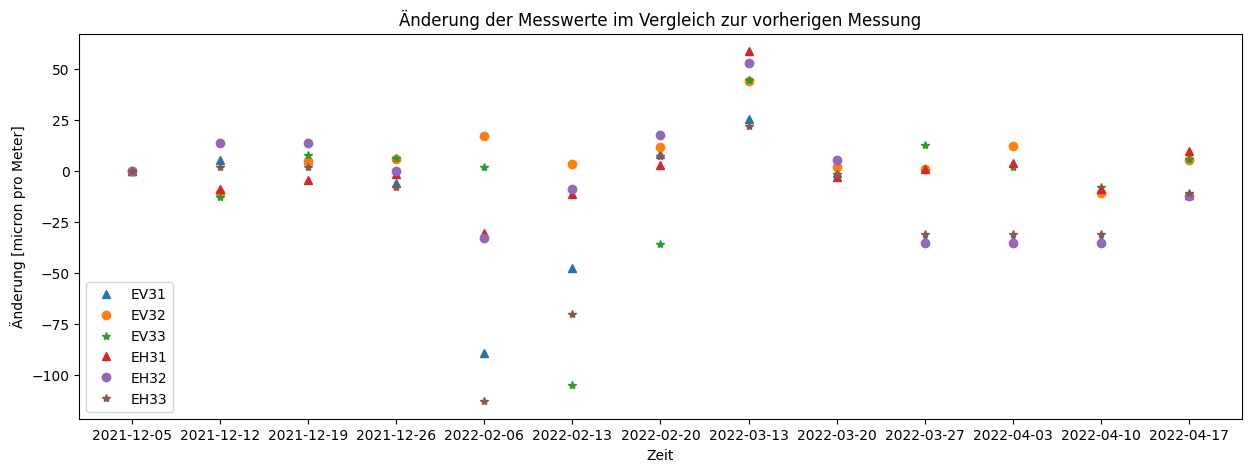

In [ ]:
# For each strain gauge, compute the delta relative to the previous measurement

plt.figure(figsize=(15,5))
plt.title('Änderung der Messwerte im Vergleich zur vorherigen Messung')
plt.plot(df_delta.EV31, marker='^', linestyle='', label='EV31')
plt.plot(df_delta.EV32, marker='o', linestyle='', label='EV32')
plt.plot(df_delta.EV33, marker='*', linestyle='', label='EV33')

plt.plot(df_delta.EH31, marker='^', linestyle='', label='EH31')
plt.plot(df_delta.EH32, marker='o', linestyle='', label='EH32')
plt.plot(df_delta.EH33, marker='*', linestyle='', label='EH33')

plt.xlabel('Zeit')
plt.ylabel('Änderung [micron pro Meter]')

plt.legend()
plt.show()

**Conclusion:** No strain gauge shows a clearly anomalous behaviour.

## Investigation of R-squared
In this short section we fit one single plane to both the grouted and the single piles. We use the resulting value of R-squared as a proxy in order to understand what baseline is better to use (July vs. November 2021), or if it makes sense to switch the columns EH31 and EV31.


In [ ]:
# Sum of all R_squared values

not_usable_measurements = ['2022-01-02', '2022-01-09', '2022-01-16', '2022-01-23', '2022-01-30', '2022-02-27', '2022-03-06']

all_measurements = ['2021-12-05', '2021-12-12', '2021-12-19', '2021-12-26', '2022-01-02',
                    '2022-01-09', '2022-01-16', '2022-01-23', '2022-01-30', '2022-02-06',
                    '2022-02-13', '2022-02-20', '2022-02-27', '2022-03-06', '2022-03-13',
                    '2022-03-20', '2022-03-27', '2022-04-03', '2022-04-10', '2022-04-17']

sum_R_squared = 0

for measurement in all_measurements:

  if measurement in not_usable_measurements:
    print(f'No analysis during this period: {measurement}')
  else:
    df = select_data(depth = 7.5, type_bohlen = 'vorverklebte', measurement_date = measurement)
    coef = _interpolation_DB(df)
    sum_R_squared += coef[3]

sum_R_squared

5 strain data points available, an analysis of static behaviour can be performed
5 strain data points available, an analysis of static behaviour can be performed
5 strain data points available, an analysis of static behaviour can be performed
5 strain data points available, an analysis of static behaviour can be performed
No analysis during this period: 2022-01-02
No analysis during this period: 2022-01-09
No analysis during this period: 2022-01-16
No analysis during this period: 2022-01-23
No analysis during this period: 2022-01-30
5 strain data points available, an analysis of static behaviour can be performed
5 strain data points available, an analysis of static behaviour can be performed
5 strain data points available, an analysis of static behaviour can be performed
No analysis during this period: 2022-02-27
No analysis during this period: 2022-03-06
5 strain data points available, an analysis of static behaviour can be performed
5 strain data points available, an analysis of stat

7.998070207634894

In [ ]:
# Sum of all R_squared values for Einzelbohlen unten

# Baseline July, no switching of columns
# 7.254635698038917
# R^2 = 0.56 (average)
# neutral axis always the same


# Baseline July, switch the columns
# 8.179863015686859
# R^2 = 0.63 (average)
# neutral axis always the same


# Baseline November, no switching of columns
# 4.9394788876421565
# R^2 = 0.38 (average)
# neutral axis changes and looks weird


# Baseline November, switch the columns
# 5.522191437186081
# R^2 = 0.42 (average)
# neutral axis changes slightly after beginning of February

In [ ]:
# Sum of all R_squared values for vorverklebte Bohlen unten

# Baseline July
# 3.8384255107119003
# R^2 = 0.30 (average)
# neutral axis always the same


# Baseline November
# 7.998070207634894
# R^2 = 0.62 (average)

**Conclusions:**
It cannot be definitively concluded which baseline works better. In the case of gouted sheet piles, November is a clearly superior fit. For the singles sheet piles, on the other hand, July delivers higher values of R-squared.
Switching the columns (strain guages EH31 and EV31) leads to a slightly better fit, but the difference does not appear to be significant.

## Plausibility check at varying depths
Let's investigate the trend of three strain gauges that were placed at the same location in the cross section, but at different depths:

*   EH11, EH21, EH31
*   EV12, EV22, EV32
*   W12, W22, W32
*   W13, W23, W33
*   VH12, VH22, VH32

According to our calculation in Larix and in Plaxis 2D, we expect the following moments:

*   z = 2.0m: lowest moment (order of magnitude of a few kNm/m)
*   z = 4.5m: highest moment (between 30 and 56 kNm/m)
*   z = 7.5m: middle moment (between 20 and 25 kNm/m)

This pattern should be reflected in the strain gauges data.

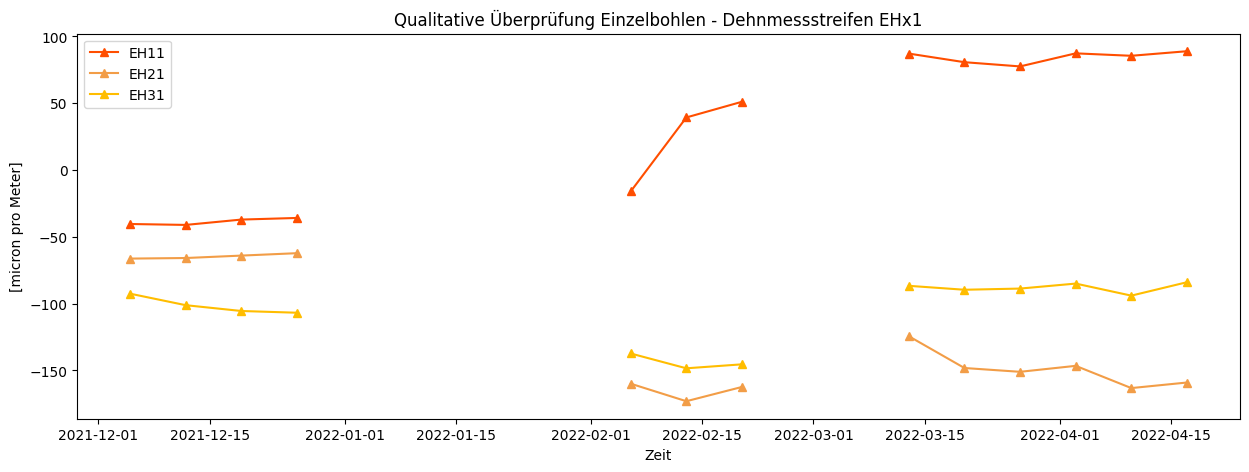

In [ ]:
# Einzehlbohlen EH11, EH21, EH31 (same location, different depths)

plt.figure(figsize=(15,5))
plt.title('Qualitative Überprüfung Einzelbohlen - Dehnmessstreifen EHx1')
plt.plot(df_dms.EH11, marker='^', linestyle='-', label='EH11', color='#ff4e00')
plt.plot(df_dms.EH21, marker='^', linestyle='-', label='EH21', color='#f29d47')
plt.plot(df_dms.EH31, marker='^', linestyle='-', label='EH31', color='#ffbd00')
plt.xlabel('Zeit')
plt.ylabel('[micron pro Meter]')
plt.legend()
plt.show()

# EH11 shows the biggest change --> This does not correspond to our expectations.
# EH11 and EH21 show opposite trends (increase vs. decrease) --> This does not correspond to our expectations.

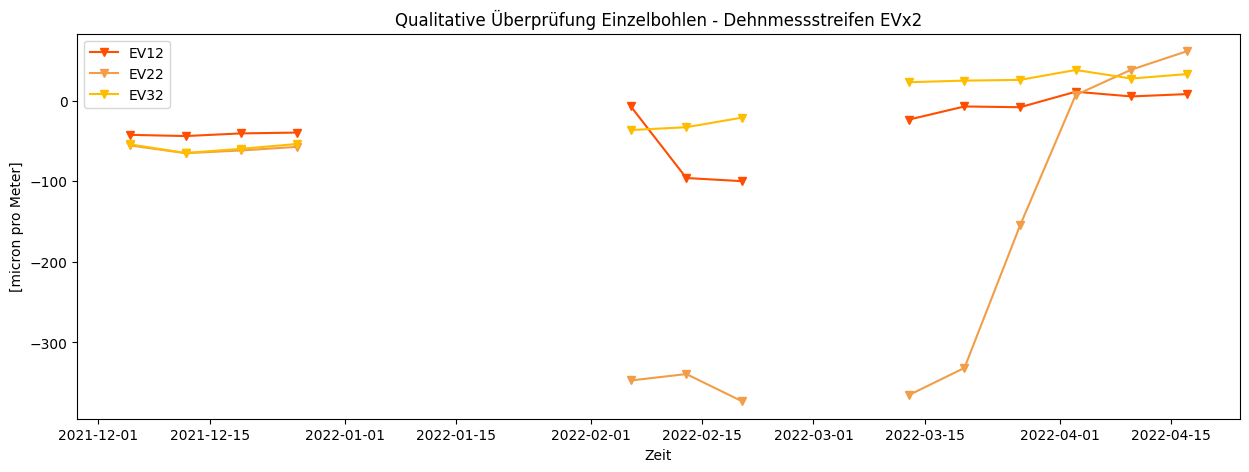

In [ ]:
# Einzehlbohlen EV12, EV22, EV32 (same location, different depths)

plt.figure(figsize=(15,5))
plt.title('Qualitative Überprüfung Einzelbohlen - Dehnmessstreifen EVx2')
plt.plot(df_dms.EV12, marker='v', linestyle='-', label='EV12', color='#ff4e00')
plt.plot(df_dms.EV22, marker='v', linestyle='-', label='EV22', color='#f29d47')
plt.plot(df_dms.EV32, marker='v', linestyle='-', label='EV32', color='#ffbd00')
plt.xlabel('Zeit')
plt.ylabel('[micron pro Meter]')
plt.legend()
plt.show()

# The development of EV22 does not look plausible. Furthermore, the herein observed
# patterns do not correspond to the patterns observed for EH11, EH21, EH31.

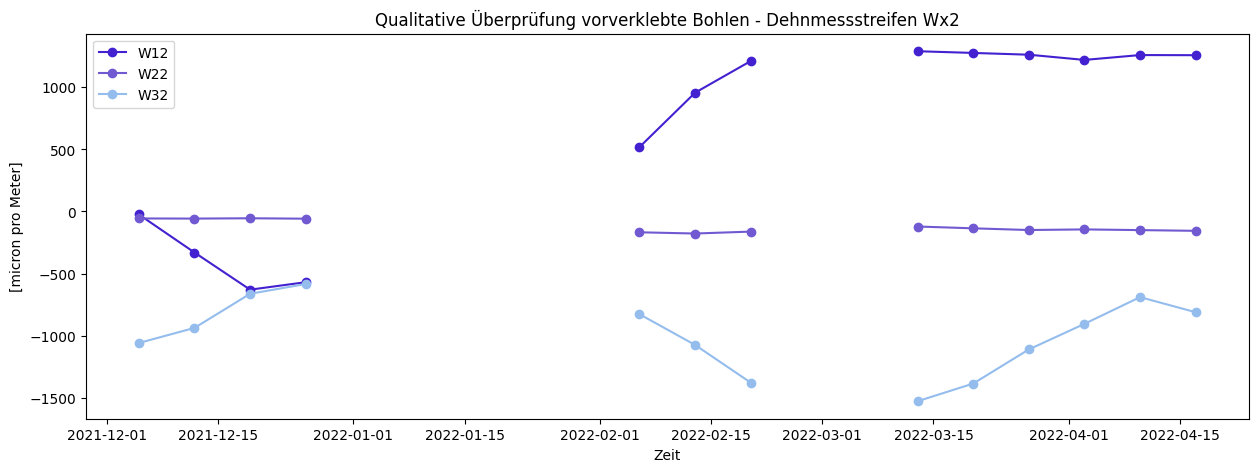

In [ ]:
# Vorverklebte Bohlen W12, W22, W32 (same location, different depths)

plt.figure(figsize=(15,5))
plt.title('Qualitative Überprüfung vorverklebte Bohlen - Dehnmessstreifen Wx2')
plt.plot(df_dms.W12, marker='o', linestyle='-', label='W12', color='#4321d0')
plt.plot(df_dms.W22, marker='o', linestyle='-', label='W22', color='#715ad1')
plt.plot(df_dms.W32, marker='o', linestyle='-', label='W32', color='#94bded')
plt.xlabel('Zeit')
plt.ylabel('[micron pro Meter]')
plt.legend()
plt.show()

# The strain gauge W22 shows the smallest variation. This does not correspond to our expectations.
# W12 and W32 show opposite trends (increase vs. decrease). This does not correspond to our expectations.

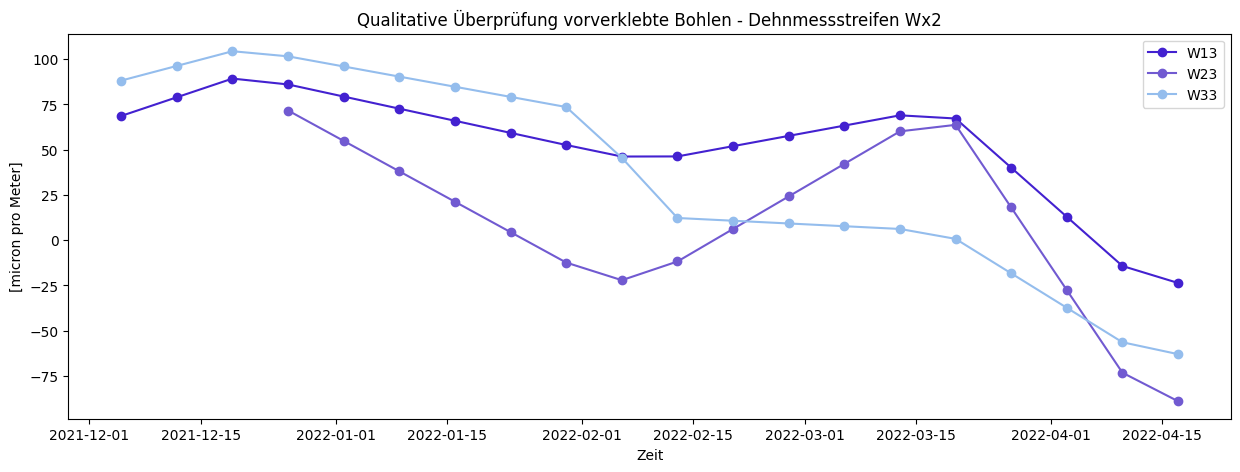

In [ ]:
# Vorverklebte Bohlen W13, W23, W33 (same location, different depths)

plt.figure(figsize=(15,5))
plt.title('Qualitative Überprüfung vorverklebte Bohlen - Dehnmessstreifen Wx2')
plt.plot(df_dms.W13, marker='o', linestyle='-', label='W13', color='#4321d0')
plt.plot(df_dms.W23, marker='o', linestyle='-', label='W23', color='#715ad1')
plt.plot(df_dms.W33, marker='o', linestyle='-', label='W33', color='#94bded')
plt.xlabel('Zeit')
plt.ylabel('[micron pro Meter]')
plt.legend()
plt.show()

# W13 shows the smallest variation. This does correspond to our expectation :)
# W23 shows a very weird trend!
# W33 delievers at the qualitative level plausible results.

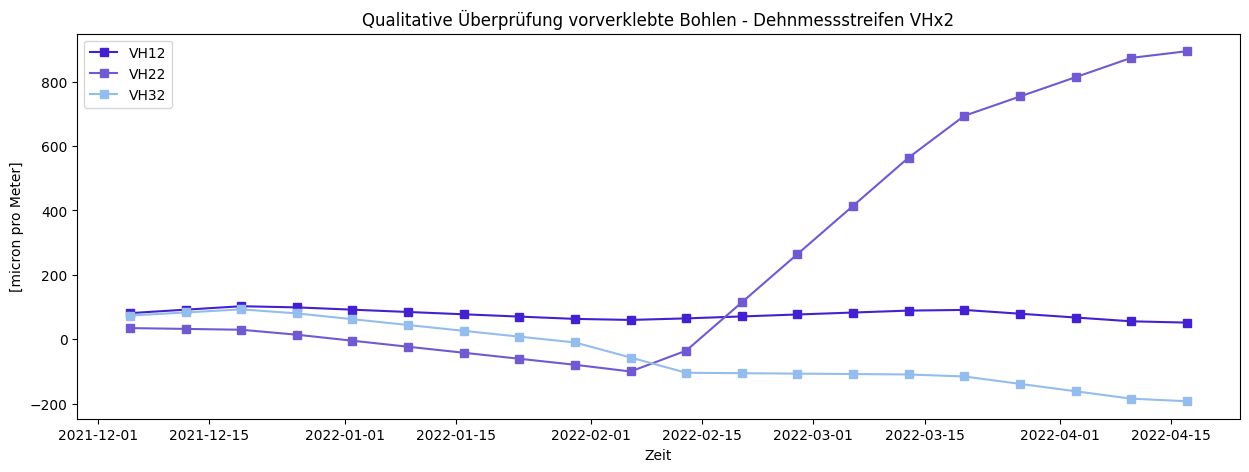

In [ ]:
# Vorverklebte Bohlen VH12, VH22, VH32 (same location, different depths)

plt.figure(figsize=(15,5))
plt.title('Qualitative Überprüfung vorverklebte Bohlen - Dehnmessstreifen VHx2')
plt.plot(df_dms.VH12, marker='s', linestyle='-', label='VH12', color='#4321d0')
plt.plot(df_dms.VH22, marker='s', linestyle='-', label='VH22', color='#715ad1')
plt.plot(df_dms.VH32, marker='s', linestyle='-', label='VH32', color='#94bded')
plt.xlabel('Zeit')
plt.ylabel('[micron pro Meter]')
plt.legend()
plt.show()

# VH12 shows the smallest variation. This does correspond to our expectations.
# VH22 shows the biggest variation and an increase. This does correspond to our expectations.
# VH32 shows some variation, even though in the opposite direction of VH22. Situation unclear.

## Plausibility check for each cross-section
Let's analyse the developement of the strain in each cross-section. The sheet piles bend as a result of the ongoing excavation.

*   tension: the strain increases
*   compression: the strain decreases
*   no strain / stress: on the neutral axis

This pattern should be reflected in the strain gauges data.


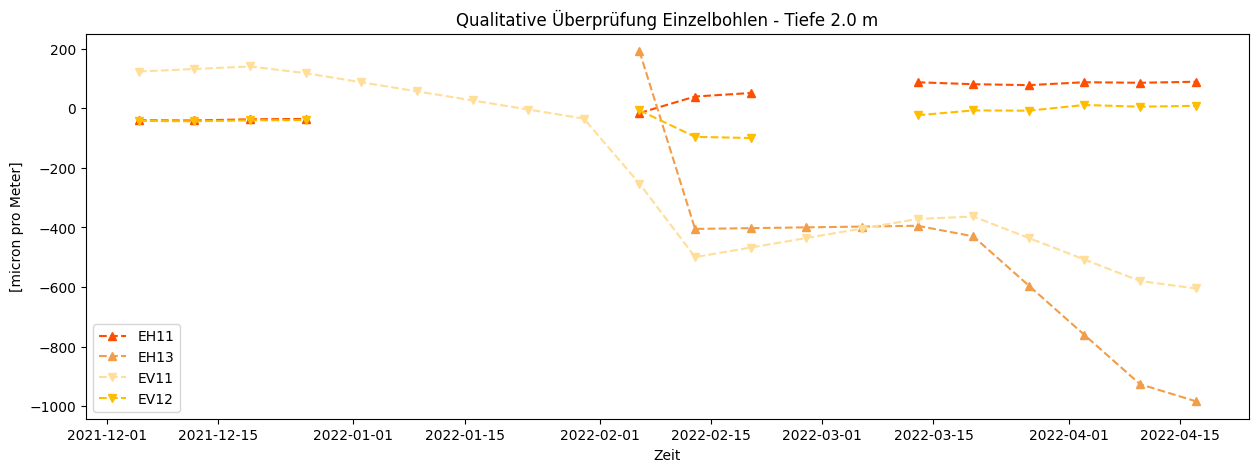

In [ ]:
# Einzehlbohlen EH11, EH13, EV12 (depth 2.0 m)
# What do we expect?
# EH11: compression
# EH13: barely any change
# EV11: tension
# EV12: tension

plt.figure(figsize=(15,5))
plt.title('Qualitative Überprüfung Einzelbohlen - Tiefe 2.0 m')
plt.plot(df_dms.EH11, marker='^', linestyle='--', label='EH11', color='#ff4e00')
plt.plot(df_dms.EH13, marker='^', linestyle='--', label='EH13', color='#f29d47')
plt.plot(df_dms.EV11, marker='v', linestyle='--', label='EV11', color='#ffde99')
plt.plot(df_dms.EV12, marker='v', linestyle='--', label='EV12', color='#ffbd00')
plt.xlabel('Zeit')
plt.ylabel('[micron pro Meter]')
plt.legend()
plt.show()

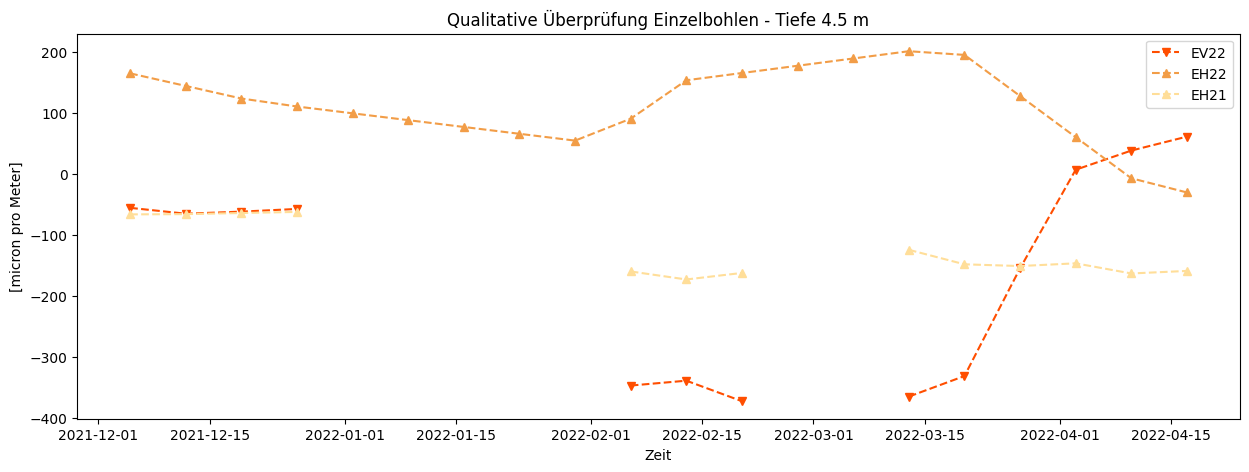

In [ ]:
# Einzehlbohlen EV22, EH22, EH21 (depth 4.5 m)
# What do we expect?
# EV22: tension
# EH22: compression
# EH21: compression

plt.figure(figsize=(15,5))
plt.title('Qualitative Überprüfung Einzelbohlen - Tiefe 4.5 m')
plt.plot(df_dms.EV22, marker='v', linestyle='--', label='EV22', color='#ff4e00')
plt.plot(df_dms.EH22, marker='^', linestyle='--', label='EH22', color='#f29d47')
plt.plot(df_dms.EH21, marker='^', linestyle='--', label='EH21', color='#ffde99')
plt.xlabel('Zeit')
plt.ylabel('[micron pro Meter]')
plt.legend()
plt.show()

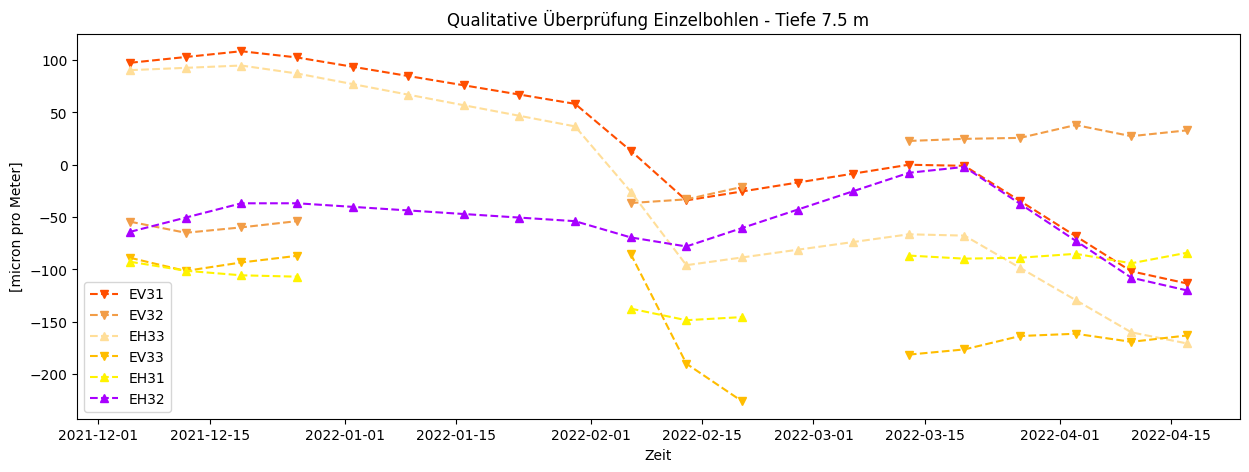

In [ ]:
# Einzehlbohlen EV31, EV32, EV33, EH31, EH32, EH33 (depth 7.5 m)
# What do we expect?
# EV31, EV32: tension
# EH33, EV33: barely any change
# EH31, EH32: compression

plt.figure(figsize=(15,5))
plt.title('Qualitative Überprüfung Einzelbohlen - Tiefe 7.5 m')
plt.plot(df_dms.EV31, marker='v', linestyle='--', label='EV31', color='#ff4e00')
plt.plot(df_dms.EV32, marker='v', linestyle='--', label='EV32', color='#f29d47')
plt.plot(df_dms.EH33, marker='^', linestyle='--', label='EH33', color='#ffde99')
plt.plot(df_dms.EV33, marker='v', linestyle='--', label='EV33', color='#ffbd00')
plt.plot(df_dms.EH31, marker='^', linestyle='--', label='EH31', color='#fff300')
plt.plot(df_dms.EH32, marker='^', linestyle='--', label='EH32', color='#a800ff')
plt.xlabel('Zeit')
plt.ylabel('[micron pro Meter]')
plt.legend()
plt.show()

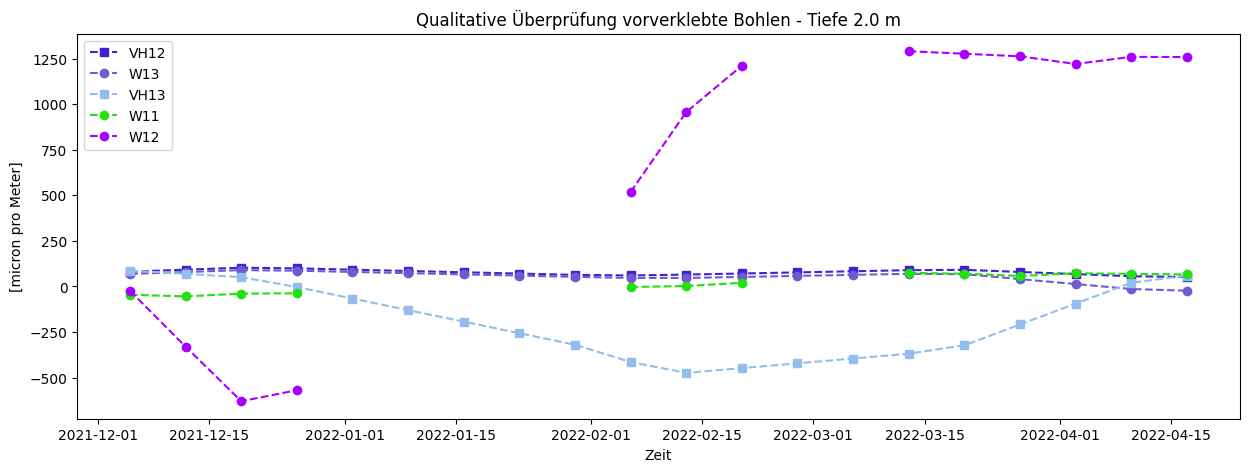

In [ ]:
# Vorverklebte Bohlen (depth 2.0 m)
# What do we expect?
# VH12: tension
# W13, VH13: barely any change, similar trend
# W11, W12: compression

plt.figure(figsize=(15,5))
plt.title('Qualitative Überprüfung vorverklebte Bohlen - Tiefe 2.0 m')
plt.plot(df_dms.VH12, marker='s', linestyle='--', label='VH12', color='#4321d0')
plt.plot(df_dms.W13, marker='o', linestyle='--', label='W13', color='#715ad1')
plt.plot(df_dms.VH13, marker='s', linestyle='--', label='VH13', color='#94bded')
plt.plot(df_dms.W11, marker='o', linestyle='--', label='W11', color='#22e111')
plt.plot(df_dms.W12, marker='o', linestyle='--', label='W12', color='#a800ff')
plt.xlabel('Zeit')
plt.ylabel('[micron pro Meter]')
plt.legend()
plt.show()

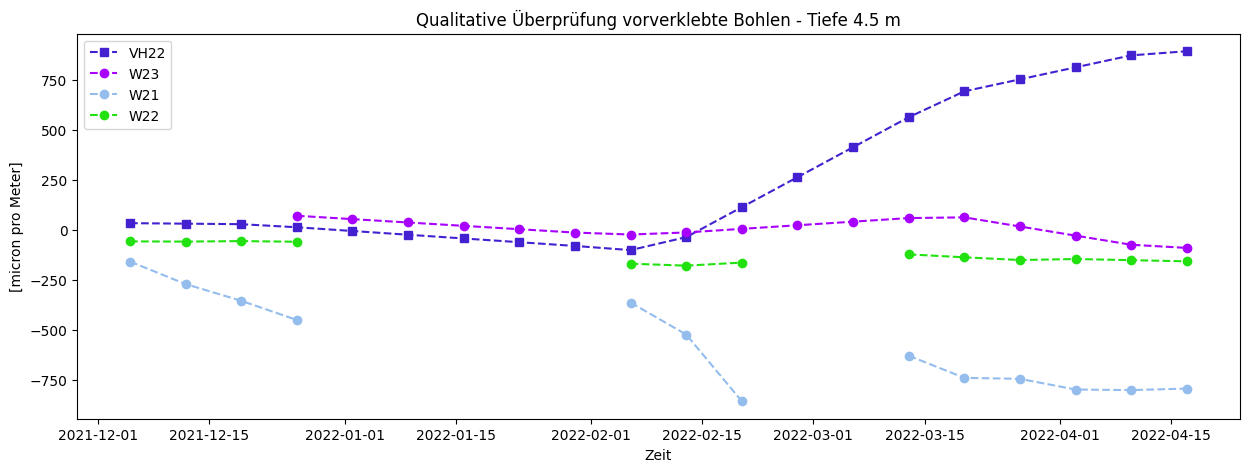

In [ ]:
# Vorverklebte Bohlen VH22, W23, W22, W21 (depth 4.5 m)
# What do we expect?
# VH22: tension
# W23: barely any change, similar trend
# W22, W21: compression

plt.figure(figsize=(15,5))
plt.title('Qualitative Überprüfung vorverklebte Bohlen - Tiefe 4.5 m')
plt.plot(df_dms.VH22, marker='s', linestyle='--', label='VH22', color='#4321d0')
plt.plot(df_dms.W23, marker='o', linestyle='--', label='W23', color='#a800ff')
plt.plot(df_dms.W21, marker='o', linestyle='--', label='W21', color='#94bded')
plt.plot(df_dms.W22, marker='o', linestyle='--', label='W22', color='#22e111')
plt.xlabel('Zeit')
plt.ylabel('[micron pro Meter]')
plt.legend()
plt.show()

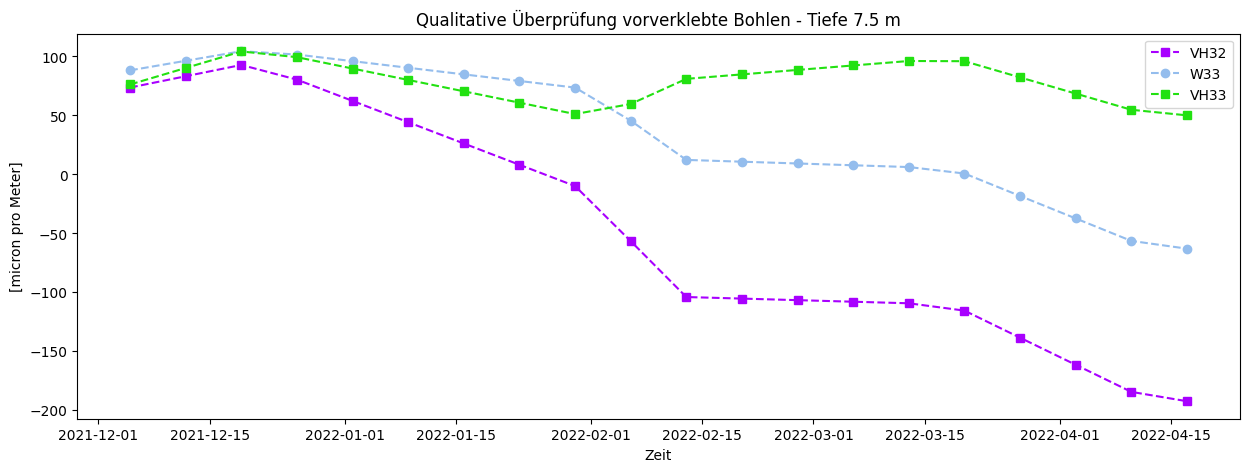

In [ ]:
# Vorverklebte Bohlen (depth 7.5 m)
# What do we expect?
# VH31, VH32: tension
# W33, VH33: barely any change, similar trend
# W32: compression

plt.figure(figsize=(15,5))
plt.title('Qualitative Überprüfung vorverklebte Bohlen - Tiefe 7.5 m')
#plt.plot(df_dms.VH31, marker='s', linestyle='--', label='VH31', color='#4321d0')
plt.plot(df_dms.VH32, marker='s', linestyle='--', label='VH32', color='#a800ff')
plt.plot(df_dms.W33, marker='o', linestyle='--', label='W33', color='#94bded')
plt.plot(df_dms.VH33, marker='s', linestyle='--', label='VH33', color='#22e111')
#plt.plot(df_dms.W32, marker='o', linestyle='--', label='W32', color='#715ad1')
plt.xlabel('Zeit')
plt.ylabel('[micron pro Meter]')
plt.legend()
plt.show()

In [ ]:
my_df = select_data(depth = 4.5, type_bohlen = 'vorverklebte', measurement_date = '2021-12-26')
my_df.loc['W22', 'strain'] = np.nan
#my_df
my_coef = _interpolation_DB(my_df)
_representation_DB(my_coef, my_df)

4 strain data points available, an analysis of static behaviour can be performed


In [ ]:
my_df = select_data(depth = 4.5, type_bohlen = 'vorverklebte', measurement_date = '2022-02-06')
my_df.loc['W22', 'strain'] = np.nan # W22 values seem nonsense
my_coef = _interpolation_DB(my_df)
_representation_DB(my_coef, my_df)

4 strain data points available, an analysis of static behaviour can be performed


In [ ]:
my_df = select_data(depth = 4.5, type_bohlen = 'vorverklebte', measurement_date = '2022-03-13')
my_df.loc['W22', 'strain'] = np.nan # W22 values seem nonsense
my_coef = _interpolation_DB(my_df)
_representation_DB(my_coef, my_df)

4 strain data points available, an analysis of static behaviour can be performed


In [ ]:
my_df = select_data(depth = 4.5, type_bohlen = 'vorverklebte', measurement_date = '2022-03-20')
my_df.loc['W22', 'strain'] = np.nan # W22 values seem nonsense
my_coef = _interpolation_DB(my_df)
_representation_DB(my_coef, my_df)

4 strain data points available, an analysis of static behaviour can be performed


In [ ]:
my_df = select_data(depth = 4.5, type_bohlen = 'vorverklebte', measurement_date = '2022-04-17')
my_df.loc['W22', 'strain'] = np.nan # W22 values seem nonsense
my_coef = _interpolation_DB(my_df)
_representation_DB(my_coef, my_df)

4 strain data points available, an analysis of static behaviour can be performed


## Conclusions

It must be concluded that the strain gauges data cannot be used to evaluate the static behaviour of the sheet piles.